In [11]:
import pandas as pd

import CDS_API
import Meteo_vars
import importlib

import xarray as xr
xr.set_options(display_expand_attrs=True, display_width=1000, display_max_rows=1000)


importlib.reload(CDS_API)
importlib.reload(Meteo_vars)

<module 'Meteo_vars' from 'c:\\Users\\dias3\\Desktop\\FIRE-HACK\\Notebooks\\5Deployment\\backend\\utils\\Meteo_vars.py'>

In [12]:
# inputs da interface

duration = 4

mins_since_fire_start = 0

start_time = pd.to_datetime("2017-10-15 14:20:00")

In [13]:
netcdf = 1  # initialize flag

try:
    ds_complete = xr.open_dataset(r"Data\Meteo_Complete.nc")
except FileNotFoundError:
    netcdf = 0
    ds_complete = None

In [14]:
end_time = start_time + pd.Timedelta(hours=duration)

API_times = pd.date_range(
    start=start_time.ceil("h"),
    end=end_time.floor("h"),
    freq="1h"
).to_list()

print(API_times)

[Timestamp('2017-10-15 15:00:00'), Timestamp('2017-10-15 16:00:00'), Timestamp('2017-10-15 17:00:00'), Timestamp('2017-10-15 18:00:00')]


In [15]:
# Se o NetCDF existe
if netcdf == 1:
    missing_times = [t for t in API_times if t not in ds_complete.valid_time]
else:
    missing_times = API_times  # todos os horários precisam ser baixados

if missing_times:
    years  = sorted(set(t.year for t in missing_times))
    months = sorted(set(t.month for t in missing_times))
    days   = sorted(set(t.day for t in missing_times))
    hours  = sorted(set(t.hour for t in missing_times))

    print("Baixando dados para os horários faltantes:")
    print("Years:", years)
    print("Months:", months)
    print("Days:", days)
    print("Hours:", hours)

    # Baixa os dados do ERA5
    era5_output = CDS_API.fetch_era5_data(years, months, days, hours)
else:
    era5_output = None

print("Processo concluído.")


Baixando dados para os horários faltantes:
Years: [2017]
Months: [10]
Days: [15]
Hours: [18]


Requesting: ERA5_SL_2017_10_15_18.nc


2025-11-28 16:42:04,930 INFO Request ID is 83ab8995-1cfb-4b4f-bfb0-152901aad1bb
2025-11-28 16:42:05,019 INFO status has been updated to accepted
2025-11-28 16:42:10,040 INFO status has been updated to running
2025-11-28 16:42:18,656 INFO status has been updated to successful


963ae5b73451e54cef2a01bd10721be.nc:   0%|          | 0.00/55.0k [00:00<?, ?B/s]

2025-11-28 16:42:19,570 INFO Request ID is 63fd698c-2809-4132-a952-7e140c1eb0a9


Requesting: ERA5_PL_2017_10_15_18.nc


2025-11-28 16:42:19,641 INFO status has been updated to accepted
2025-11-28 16:42:28,057 INFO status has been updated to running
2025-11-28 16:42:40,902 INFO status has been updated to successful


65365af9a1740c9566516775b4540842.nc:   0%|          | 0.00/65.1k [00:00<?, ?B/s]

Requesting: ERA5_FWI_2017_10_15_18.nc


2025-11-28 16:42:42,007 INFO Request ID is 93d9069f-4fe5-4f53-9dff-4cdd9bbffaec
2025-11-28 16:42:42,095 INFO status has been updated to accepted
2025-11-28 16:42:50,601 INFO status has been updated to running
2025-11-28 16:42:55,751 INFO status has been updated to successful


9e65bdfd07fbcd4a9343a43ed1ce8531.nc:   0%|          | 0.00/23.1k [00:00<?, ?B/s]

Processo concluído.


In [16]:
import xarray as xr
from pathlib import Path

if era5_output:
    for name, filepath in era5_output.items():
        print(f"\n=== {name.upper()} ===")
        
        # Abrir o NetCDF com xarray
        ds = xr.open_dataset(filepath)
        
        # Print resumido das dimensões, coordenadas e variáveis
        print(ds)
        
        # Se quiseres printar só as variáveis:
        print("\nVariáveis disponíveis:")
        print(list(ds.data_vars))
        
        # Para fechar o dataset explicitamente (boa prática)
        ds.close()



=== SINGLE_LEVELS ===
<xarray.Dataset> Size: 8kB
Dimensions:     (valid_time: 1, latitude: 29, longitude: 17)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 8B 2017-10-15T18:00:00
  * latitude    (latitude) float64 232B 43.0 42.75 42.5 42.25 42.0 41.75 41.5 41.25 41.0 40.75 40.5 40.25 40.0 39.75 39.5 39.25 39.0 38.75 38.5 38.25 38.0 37.75 37.5 37.25 37.0 36.75 36.5 36.25 36.0
  * longitude   (longitude) float64 136B -10.0 -9.75 -9.5 -9.25 -9.0 -8.75 -8.5 -8.25 -8.0 -7.75 -7.5 -7.25 -7.0 -6.75 -6.5 -6.25 -6.0
    number      int64 8B ...
    expver      <U4 16B ...
Data variables:
    u100        (valid_time, latitude, longitude) float32 2kB ...
    v100        (valid_time, latitude, longitude) float32 2kB ...
    swvl3       (valid_time, latitude, longitude) float32 2kB ...
    cape        (valid_time, latitude, longitude) float32 2kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_sub

In [17]:
if era5_output:
    # Preparar os datasets
    ds_SL, ds_PL, ds_FWI = Meteo_vars.prepare_datasets(
        sl_file= era5_output['single_levels'],
        pl_file= era5_output['pressure_levels'],
        fwi_file= era5_output['fwi']
    )

    # Conferir shapes
    print(ds_SL)
    print(ds_PL)
    print(ds_FWI)

Loading datasets...
Interpolating ERA5 datasets to 0.1° grid...
Regridding FWI dataset to match ERA5 grid...
Interpolating FWI to regular grid...
<xarray.Dataset> Size: 82kB
Dimensions:     (valid_time: 1, latitude: 62, longitude: 41)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 8B 2017-10-15T18:00:00
  * latitude    (latitude) float64 496B 43.0 42.9 42.8 42.7 42.6 42.5 42.4 42.3 42.2 42.1 42.0 41.9 41.8 41.7 41.6 41.5 41.4 41.3 41.2 41.1 41.0 40.9 40.8 40.7 40.6 40.5 40.4 40.3 40.2 40.1 40.0 39.9 39.8 39.7 39.6 39.5 39.4 39.3 39.2 39.1 39.0 38.9 38.8 38.7 38.6 38.5 38.4 38.3 38.2 38.1 38.0 37.9 37.8 37.7 37.6 37.5 37.4 37.3 37.2 37.1 37.0 36.9
  * longitude   (longitude) float64 328B -10.0 -9.9 -9.8 -9.7 -9.6 -9.5 -9.4 -9.3 -9.2 -9.1 -9.0 -8.9 -8.8 -8.7 -8.6 -8.5 -8.4 -8.3 -8.2 -8.1 -8.0 -7.9 -7.8 -7.7 -7.6 -7.5 -7.4 -7.3 -7.2 -7.1 -7.0 -6.9 -6.8 -6.7 -6.6 -6.5 -6.4 -6.3 -6.2 -6.1 -6.0
Data variables:
    u100_ms     (valid_time, latitude, longitude) float64 20kB -2.466 -2

c:\Users\dias3\Desktop\FIRE-HACK\Notebooks\5Deployment\backend\utils\Meteo_vars.py:70: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  times_hourly = pd.date_range(


In [18]:
if era5_output:
    ds_meteovars = Meteo_vars.calculate_weather_variables(ds_SL, ds_PL, ds_FWI)

    print(ds_meteovars)

Converting units...
Calculating derived variables...
<xarray.Dataset> Size: 123kB
Dimensions:         (valid_time: 1, latitude: 62, longitude: 41)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 8B 2017-10-15T18:00:00
  * latitude        (latitude) float64 496B 43.0 42.9 42.8 42.7 42.6 42.5 42.4 42.3 42.2 42.1 42.0 41.9 41.8 41.7 41.6 41.5 41.4 41.3 41.2 41.1 41.0 40.9 40.8 40.7 40.6 40.5 40.4 40.3 40.2 40.1 40.0 39.9 39.8 39.7 39.6 39.5 39.4 39.3 39.2 39.1 39.0 38.9 38.8 38.7 38.6 38.5 38.4 38.3 38.2 38.1 38.0 37.9 37.8 37.7 37.6 37.5 37.4 37.3 37.2 37.1 37.0 36.9
  * longitude       (longitude) float64 328B -10.0 -9.9 -9.8 -9.7 -9.6 -9.5 -9.4 -9.3 -9.2 -9.1 -9.0 -8.9 -8.8 -8.7 -8.6 -8.5 -8.4 -8.3 -8.2 -8.1 -8.0 -7.9 -7.8 -7.7 -7.6 -7.5 -7.4 -7.3 -7.2 -7.1 -7.0 -6.9 -6.8 -6.7 -6.6 -6.5 -6.4 -6.3 -6.2 -6.1 -6.0
    pressure_level  float64 8B 850.0
Data variables:
    sW_100          (valid_time, latitude, longitude) float64 20kB 1.024e-05 1.024e-05 1.024e-05 1.024e-05 1.02

In [19]:
if era5_output:
    if ds_complete is not None:
        # Merge com o dataset existente
        print(ds_complete)
        print(ds_meteovars)
        ds_complete = xr.concat([ds_complete, ds_meteovars], dim="valid_time")
    else:
        # Se não existe dataset, cria diretamente
        ds_complete = ds_meteovars

    ds_complete.to_netcdf(r"Data\Meteo_Complete.nc")

<xarray.Dataset> Size: 367kB
Dimensions:         (valid_time: 3, latitude: 62, longitude: 41)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 24B 2017-10-15T15:00:00 2017-10-15T16:00:00 2017-10-15T17:00:00
  * latitude        (latitude) float64 496B 43.0 42.9 42.8 42.7 42.6 42.5 42.4 42.3 42.2 42.1 42.0 41.9 41.8 41.7 41.6 41.5 41.4 41.3 41.2 41.1 41.0 40.9 40.8 40.7 40.6 40.5 40.4 40.3 40.2 40.1 40.0 39.9 39.8 39.7 39.6 39.5 39.4 39.3 39.2 39.1 39.0 38.9 38.8 38.7 38.6 38.5 38.4 38.3 38.2 38.1 38.0 37.9 37.8 37.7 37.6 37.5 37.4 37.3 37.2 37.1 37.0 36.9
  * longitude       (longitude) float64 328B -10.0 -9.9 -9.8 -9.7 -9.6 -9.5 -9.4 -9.3 -9.2 -9.1 -9.0 -8.9 -8.8 -8.7 -8.6 -8.5 -8.4 -8.3 -8.2 -8.1 -8.0 -7.9 -7.8 -7.7 -7.6 -7.5 -7.4 -7.3 -7.2 -7.1 -7.0 -6.9 -6.8 -6.7 -6.6 -6.5 -6.4 -6.3 -6.2 -6.1 -6.0
    pressure_level  float64 8B ...
Data variables:
    sW_100          (valid_time, latitude, longitude) float64 61kB ...
    FWI_12h         (valid_time, latitude, longitude) 

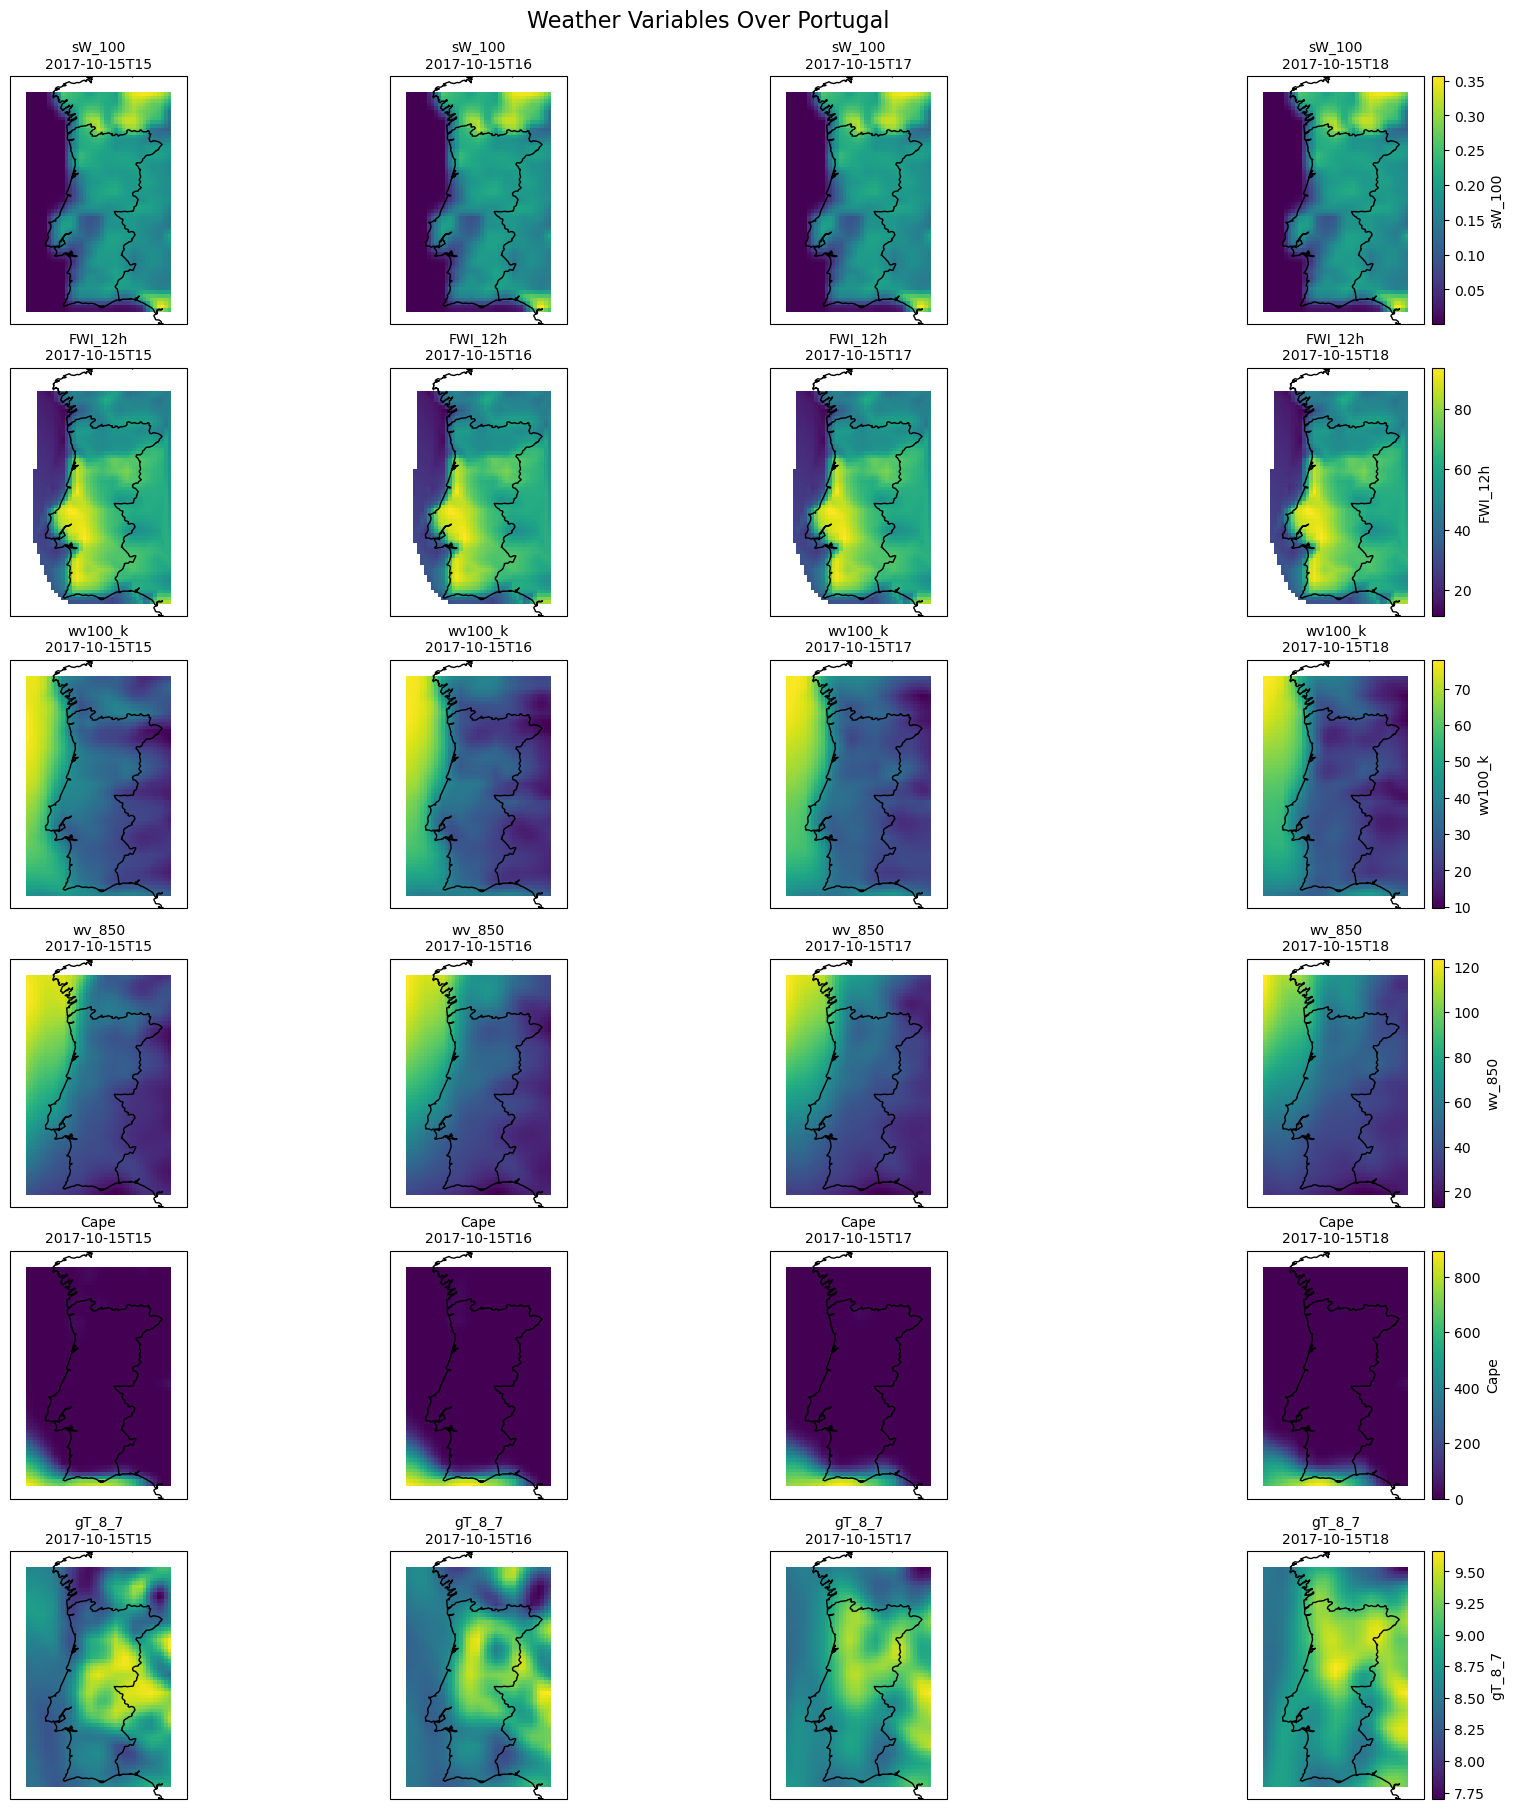

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

lats = ds_complete.latitude
lons = ds_complete.longitude
times = ds_complete.valid_time
variables = ['sW_100', 'FWI_12h', 'wv100_k', 'wv_850', 'Cape', 'gT_8_7']

n_vars = len(variables)
n_times = len(times)

# Criar figura grande
fig, axes = plt.subplots(n_vars, n_times, figsize=(4*n_times, 3*n_vars),
                         constrained_layout=True,
                         subplot_kw={'projection': ccrs.PlateCarree()})

for i, var in enumerate(variables):
    data = ds_complete[var]
    
    for j, t in enumerate(times):
        ax = axes[i, j] if n_vars > 1 and n_times > 1 else (axes[j] if n_vars==1 else axes[i])
        
        arr = data.isel(valid_time=j)
        
        # Plot dos dados
        im = ax.pcolormesh(lons, lats, arr, shading='auto', cmap='viridis')
        
        # Adicionar contorno do mapa de Portugal
        ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='black', linewidth=1)
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='black', linewidth=1)
        
        # Limites do mapa focando Portugal
        ax.set_extent([-10.5, -5.5, 36.5, 43.5], crs=ccrs.PlateCarree())
        
        # Título e labels
        ax.set_title(f"{var}\n{np.datetime_as_string(t.values, unit='h')}", fontsize=10)
        ax.set_xlabel("Lon")
        ax.set_ylabel("Lat")
        
        # Colorbar só para a última coluna de cada variável
        if j == n_times-1:
            cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.05, pad=0.02)
            cbar.set_label(var)

plt.suptitle("Weather Variables Over Portugal", fontsize=16)
plt.show()
